In [1]:
import pm4py
log_all = pm4py.read_xes('BPI_Challenge_2019.xes')

c:\Users\Mara Tews\Documents\Uni\RWTH_DataScience\SS_2022\SS2022_ProcessDiscoveryUsingPython\eXdpn\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 251734/251734 [03:08<00:00, 1333.10it/s]


In [2]:
print(f'activities: {list(pm4py.get_event_attribute_values(log_all,"concept:name").keys())}')

activities: ['SRM: Created', 'SRM: Complete', 'SRM: Awaiting Approval', 'SRM: Document Completed', 'SRM: In Transfer to Execution Syst.', 'SRM: Ordered', 'SRM: Change was Transmitted', 'Create Purchase Order Item', 'Vendor creates invoice', 'Record Goods Receipt', 'Record Invoice Receipt', 'Clear Invoice', 'Record Service Entry Sheet', 'SRM: Transfer Failed (E.Sys.)', 'Cancel Goods Receipt', 'Vendor creates debit memo', 'Cancel Invoice Receipt', 'Change Delivery Indicator', 'Remove Payment Block', 'SRM: Deleted', 'Change Price', 'Delete Purchase Order Item', 'SRM: Transaction Completed', 'Change Quantity', 'Change Final Invoice Indicator', 'SRM: Incomplete', 'SRM: Held', 'Receive Order Confirmation', 'Cancel Subsequent Invoice', 'Reactivate Purchase Order Item', 'Update Order Confirmation', 'Block Purchase Order Item', 'Change Approval for Purchase Order', 'Release Purchase Order', 'Record Subsequent Invoice', 'Set Payment Block', 'Create Purchase Requisition Item', 'Change Storage Loc

In [25]:
# We only look at subtraces of activities starting with 'SRM:'.
# This way we can effectively look at subtraces of a trace.
log = pm4py.filter_event_attribute_values(
    log_all,
    "concept:name",
    ['SRM: Created',
     'SRM: Complete',
     'SRM: Awaiting Approval',
     'SRM: Document Completed',
     'SRM: In Transfer to Execution Syst.',
     'SRM: Ordered',
     'SRM: Change was Transmitted',
     'SRM: Transfer Failed (E.Sys.)',
     'SRM: Deleted',
     'SRM: Transaction Completed',
     'SRM: Incomplete',
     'SRM: Held'],
    level="event",
    retain=True)

print("Number of different trace variants - subtraces: ", len(pm4py.get_variants_as_tuples(log)))

Number of different trace variants - subtraces:  59


In [26]:
log_start = pm4py.get_start_activities(log)
print(log_start)
#filtered_log = pm4py.filter_start_activities(log, 'SRM: Created')
#print("Number of different trace variants - subtraces: ", len(pm4py.get_variants_as_tuples(filtered_log)))

end_activities = pm4py.get_end_activities(log)
print(end_activities)
#filtered_log = pm4py.filter_end_activities(log, ["SRM: Change was Transmitted", 
#                                                 "SRM: Transfer Failed (E.Sys.)"])

#print("Number of different trace variants - subtraces filtered: ", len(pm4py.get_variants_as_tuples(filtered_log)))

#pm4py.write_xes(log, "BPI_Challenge_2019_srm_filtered.xes")

{'SRM: Created': 1440}
{'SRM: Change was Transmitted': 1101, 'SRM: Transfer Failed (E.Sys.)': 45, 'SRM: In Transfer to Execution Syst.': 146, 'SRM: Deleted': 108, 'SRM: Transaction Completed': 6, 'SRM: Ordered': 34}


In [27]:
# We discard less frequent variants in order to reduce
# the number of edge cases.
log = pm4py.filter_variants_top_k(log, 10)
pm4py.write_xes(log, "BPI_Challenge_2019_filtered_top_k.xes")

exporting log, completed traces :: 100%|██████████| 1349/1349 [00:01<00:00, 1296.19it/s]


### Analysis

In [1]:
import pm4py
log = pm4py.read_xes("BPI_Challenge_2019_filtered_top_k.xes")

c:\Users\Mara Tews\Documents\Uni\RWTH_DataScience\SS_2022\SS2022_ProcessDiscoveryUsingPython\eXdpn\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 1349/1349 [00:01<00:00, 1275.01it/s]


In [2]:
from exdpn.petri_net import get_petri_net

net, im, fm = get_petri_net(log, miner_type='IM')

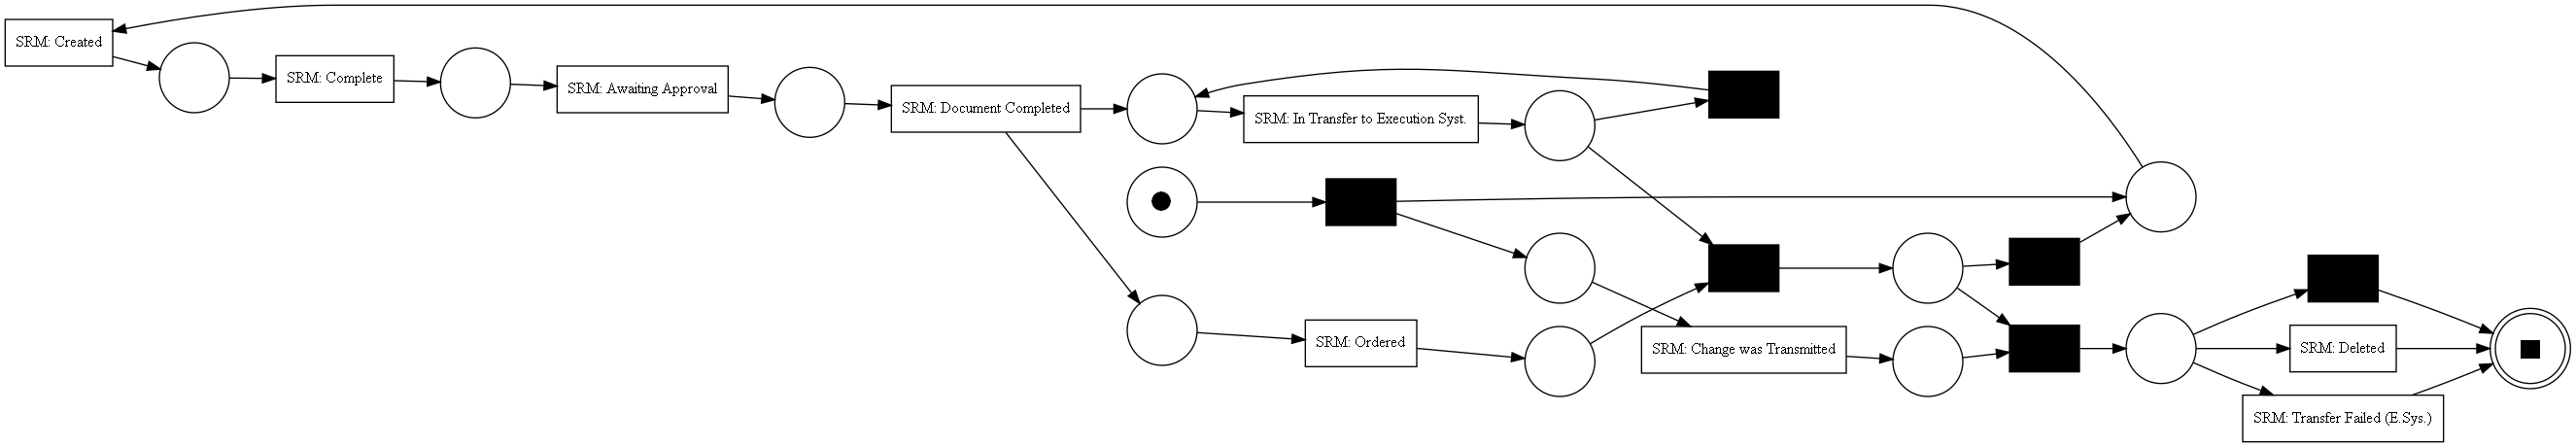

In [3]:
pm4py.view_petri_net(net, im, fm)

In [12]:
event_attrs = list(pm4py.get_event_attributes(log))
trace_attrs = list(pm4py.get_trace_attributes(log))

In [13]:
event_attrs = [attr for attr in event_attrs if max(list(pm4py.get_event_attribute_values(log, attr).values())) != 1 and "ID" not in attr]
event_attrs.remove("time:timestamp")
event_attrs.remove("org:resource")
event_attrs.remove("User")
event_attrs

['Cumulative net worth (EUR)', 'concept:name']

In [14]:
trace_attrs = [attr for attr in trace_attrs if max(list(pm4py.get_trace_attribute_values(log, attr).values())) != 1 and "ID" not in attr]
#trace_attrs.remove("Name")
trace_attrs

['Company',
 'Purchasing Document',
 'Spend classification text',
 'Document Type',
 'Item',
 'Source',
 'GR-Based Inv. Verif.',
 'Purch. Doc. Category name',
 'Spend area text',
 'Item Category',
 'Goods Receipt',
 'Name',
 'Vendor',
 'Sub spend area text',
 'Item Type']

In [55]:
from exdpn.data_petri_net import Data_Petri_Net
from exdpn.guards import ML_Technique

ml_list = [ML_Technique.DT, ML_Technique.LR, ML_Technique.RF, ML_Technique.SVM, ML_Technique.NN, ML_Technique.XGB]

dpn = Data_Petri_Net(log, petri_net=net, initial_marking=im, final_marking=fm,
                     event_level_attributes=event_attrs,
                     case_level_attributes=trace_attrs,
                     ml_list=ml_list, 
                     verbose=True, 
                     #impute=True, 
                     hyperparameters={ML_Technique.NN: {},
                                      ML_Technique.DT: {},
                                      ML_Technique.LR: {},
                                      ML_Technique.SVM: {},
                                      ML_Technique.RF: {},
                                      ML_Technique.XGB: {}})


-> Mining guard datasets... Done
-> Evaluating guards at decision point 'p_4'... 

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Done
-> Evaluating guards at decision point 'p_20'... Done
-> Evaluating guards at decision point 'p_10'... Done


In [ ]:
best = dpn.get_best()

-> Best machine learning technique at decision point 'p_4': Support Vector Machine w/ performance 0.9881047957878059
-> Best machine learning technique at decision point 'p_20': Support Vector Machine w/ performance 0.9483254821428799
-> Best machine learning technique at decision point 'p_10': Support Vector Machine w/ performance 0.9558110457055017


In [56]:
import pandas as pd

res = pd.DataFrame(columns=["place"] + [str(ml_t for ml_t in ml_list)])

for dp,gm in dpn.guard_manager_per_place.items():
    res_row = {"place":dp} | {str(ml_t):gm.f1_mean_test[ml_t] for ml_t in gm.guards_list.keys()}
    res = res.append([res_row])

res['place'] = res['place'].apply(str)
res.index = res["place"]
res.drop(["place"], axis=1, inplace=True)
res.dropna(axis=1, how="all", inplace=True)

In [57]:
res.transpose()

place,p_4,p_20,p_10
Decision Tree,0.945999,0.902966,0.911164
Logistic Regression,0.947244,0.931289,0.928425
Random Forest,0.936002,0.922304,0.919544
Support Vector Machine,0.941436,0.905856,0.930335
Neural Network,0.963406,0.908676,0.917453
XGBoost,0.945587,0.925828,0.918657


In [60]:
#import seaborn as sns
#sns.heatmap(res.transpose(), annot=True, cmap="PiYG",center=0.7)

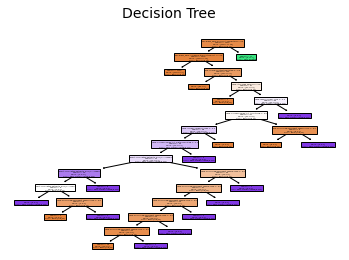

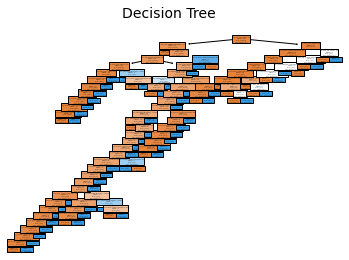

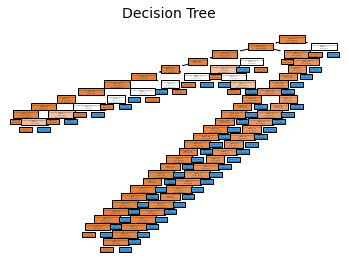

In [58]:
dps = list(dpn.decision_points)
for p in dps:
    dt_guard = dpn.guard_manager_per_place[p].guards_list[ML_Technique.DT]
    dt_explainable_representation = dt_guard.get_explainable_representation()

With hyperparameter:

In [77]:
from exdpn.data_petri_net import Data_Petri_Net
from exdpn.guards import ML_Technique

ml_list = [ML_Technique.DT, ML_Technique.LR, ML_Technique.NN, ML_Technique.SVM, ML_Technique.RF, ML_Technique.XGB]

dpn_hp = Data_Petri_Net(log, petri_net=net, initial_marking=im, final_marking=fm,
                     event_level_attributes=event_attrs,
                     case_level_attributes=trace_attrs,
                     ml_list=ml_list, 
                     verbose=True, 
                     #impute=True,
                     CV_splits = 5,
                     hyperparameters = {ML_Technique.NN: {'hidden_layer_sizes': hidden_layer_sizes}, 
                                        ML_Technique.DT: {'min_impurity_decrease': min_impurity_decrease},
                                        ML_Technique.LR: {"C": C_lr},
                                        ML_Technique.SVM: {"C": C_svm},
                                        ML_Technique.XGB: {"max_depth": max_depth_xgb},
                                        ML_Technique.RF: {'n_estimators': n_estimators,
                                                         'min_impurity_decrease': min_impurity_decrease}})

-> Mining guard datasets... Done
-> Evaluating guards at decision point 'p_4'... 

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Done
-> Evaluating guards at decision point 'p_20'... 

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Done
-> Evaluating guards at decision point 'p_10'... 

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Done


In [78]:
best_hp = dpn_hp.get_best()

-> Best machine learning technique at decision point 'p_4': Neural Network w/ performance 1.0
-> Best machine learning technique at decision point 'p_20': Support Vector Machine w/ performance 0.9658331152443177
-> Best machine learning technique at decision point 'p_10': Support Vector Machine w/ performance 0.9681710682802687


In [79]:
import pandas as pd 
res_hp = pd.DataFrame(columns=["place"] + [str(ml_t for ml_t in ml_list)])

for dp,gm in dpn_hp.guard_manager_per_place.items():
    res_row = {"place": dp} | {str(ml_t):gm.f1_mean_test[ml_t] for ml_t in gm.guards_list.keys()}
    res_hp = res_hp.append([res_row])
    
res_hp['place'] = res_hp['place'].apply(str)
res_hp.index = res_hp["place"]
res_hp.drop(["place"], axis=1, inplace=True)
res_hp.dropna(axis=1, how="all", inplace=True)

res_hp.transpose()

place,p_4,p_20,p_10
Decision Tree,0.919253,0.928215,0.923507
Logistic Regression,0.941620,0.931473,0.925289
Neural Network,0.956866,0.904837,0.926679
Support Vector Machine,0.937618,0.934934,0.927091
Random Forest,0.893485,0.928215,0.925642
XGBoost,0.945587,0.924532,0.923743


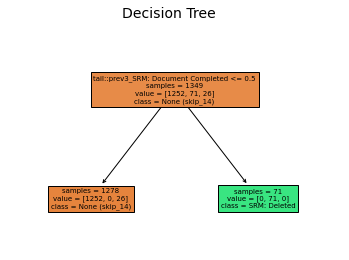

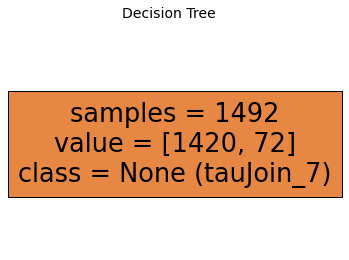

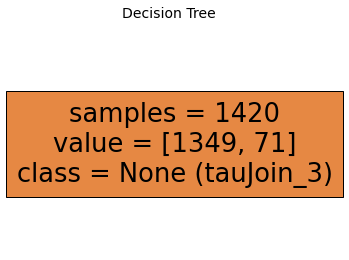

In [54]:
dps_hp = list(dpn_hp.decision_points)
for p in dps_hp:
    dt_guard = dpn_hp.guard_manager_per_place[p].guards_list[ML_Technique.DT]
    dt_explainable_representation = dt_guard.get_explainable_representation()

#### Summary:

In [59]:
res.transpose()

place,p_4,p_20,p_10
Decision Tree,0.945999,0.902966,0.911164
Logistic Regression,0.947244,0.931289,0.928425
Random Forest,0.936002,0.922304,0.919544
Support Vector Machine,0.941436,0.905856,0.930335
Neural Network,0.963406,0.908676,0.917453
XGBoost,0.945587,0.925828,0.918657


In [80]:
res_hp.transpose()

place,p_4,p_20,p_10
Decision Tree,0.919253,0.928215,0.923507
Logistic Regression,0.941620,0.931473,0.925289
Neural Network,0.956866,0.904837,0.926679
Support Vector Machine,0.937618,0.934934,0.927091
Random Forest,0.893485,0.928215,0.925642
XGBoost,0.945587,0.924532,0.923743


### Appendix: Insights to selected hyperparameters

#### Optimize DT hyperparamters with respect to explainablility:

In [65]:
from sklearn.model_selection import GridSearchCV
import numpy as np 
from exdpn.petri_net import get_petri_net
from exdpn.guard_datasets import extract_all_datasets
from exdpn.data_preprocessing import basic_data_preprocessing
from exdpn.data_preprocessing.data_preprocessing import apply_ohe, apply_scaling, fit_scaling, fit_ohe
from exdpn.guards import ML_Technique

# prepare data
dp_dataset_map = extract_all_datasets(log= log, net=net, initial_marking=im, final_marking=fm, 
                                      event_level_attributes = event_attrs,
                                      case_level_attributes=trace_attrs)

# decision points 
dps = list(dp_dataset_map.keys())

We have observed that decision trees tend to be enormously large without any hyperparameters. We thus try to find an optimal `min_impurity_decrease` value.

In [63]:
from sklearn.tree import DecisionTreeClassifier
parameters = {'min_impurity_decrease':(0, 0.01, 0.05, 0.1, 0.15)}

best_values = {}

for dp in dps:
    dp_dataset = dp_dataset_map[dp]
    X_train, y_train = basic_data_preprocessing(dp_dataset)
    ohe = fit_ohe(X_train)
    X_train = apply_ohe(X_train, ohe)
    transition_int_map = {transition: index for index,
                          transition in enumerate(list(set(y_train)))}
    y_train_mapped = [transition_int_map[transition] for transition in y_train]

    dt_base = DecisionTreeClassifier()
    dt_grid = GridSearchCV(dt_base, parameters, n_jobs=-1, scoring='f1_weighted')

    dt_grid.fit(X_train, y_train_mapped)
    print(f"{dp}:\t{round(dt_grid.best_score_,4)}\t {dt_grid.best_params_}")
    best_values[dp] = dt_grid.best_params_['min_impurity_decrease']

min_impurity_decrease = sum(val * len(dp_dataset_map[key]) for key,val in best_values.items())/sum(len(dp_dataset_map[key]) for key in best_values.keys())
print(f"final value: {min_impurity_decrease}")

p_4:	0.9714	 {'min_impurity_decrease': 0}
p_20:	0.9282	 {'min_impurity_decrease': 0.01}
p_10:	0.9256	 {'min_impurity_decrease': 0.01}
final value: 0.006834076507862005


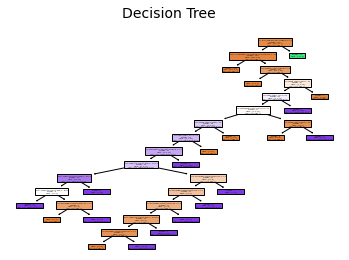

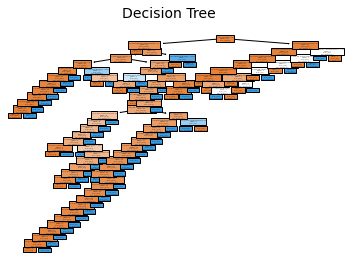

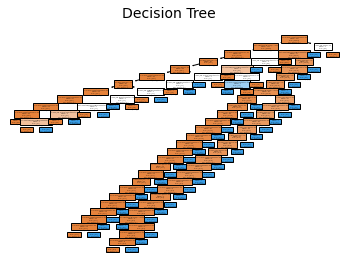

In [70]:
# decision tree without hyperparameter
for p in dps:
    dpn_temp = Data_Petri_Net(log, petri_net=net, initial_marking=im, final_marking=fm,
                              event_level_attributes=event_attrs,
                              case_level_attributes=trace_attrs,
                              ml_list=[ML_Technique.DT], 
                              verbose=False, 
                              impute=True,
                              hyperparameters = {ML_Technique.DT: {}})
    dt_guard = dpn_temp.guard_manager_per_place[p].guards_list[ML_Technique.DT]
    rep = dt_guard.get_explainable_representation()


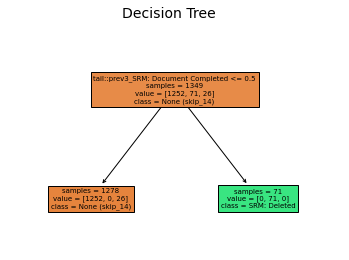

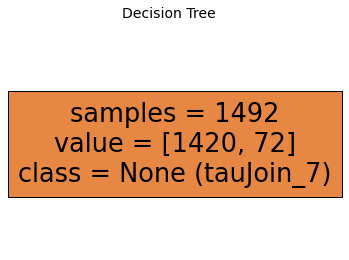

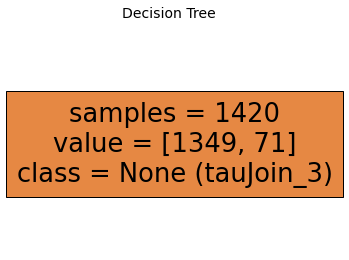

In [69]:
# decision tree with hyperparameter
for p in dps:
    dpn_temp = Data_Petri_Net(log, petri_net=net, initial_marking=im, final_marking=fm,
                              event_level_attributes=event_attrs,
                              case_level_attributes=trace_attrs,
                              ml_list=[ML_Technique.DT], 
                              verbose=False, 
                              impute=True,
                              hyperparameters = {ML_Technique.DT: {'min_impurity_decrease': min_impurity_decrease}})
    dt_guard = dpn_temp.guard_manager_per_place[p].guards_list[ML_Technique.DT]
    rep = dt_guard.get_explainable_representation()

#### Cross-Validation Neural Network

In [71]:
from sklearn.neural_network import MLPClassifier
parameters = {'hidden_layer_sizes': ((5, ), (5, 5), (10, 10), (5, 10, 5), (10, 20, 10))}

best_values = {}
max_ds_size = -1
max_ds_key = None

for dp in dps:
    dp_dataset = dp_dataset_map[dp]
    if len(dp_dataset) > max_ds_size: max_ds_key = dp
    X_train, y_train = basic_data_preprocessing(dp_dataset)
    scaler, scaler_columns = fit_scaling(X_train)
    X_train = apply_scaling(X_train, scaler, scaler_columns)
    ohe = fit_ohe(X_train)
    X_train = apply_ohe(X_train, ohe)
    transition_int_map = {transition: index for index,
                          transition in enumerate(list(set(y_train)))}
    y_train_mapped = [transition_int_map[transition] for transition in y_train]

    nn_base = MLPClassifier()
    nn_grid = GridSearchCV(nn_base, parameters, n_jobs=-1, scoring='f1_weighted')

    nn_grid.fit(X_train, y_train_mapped)
    print(f"{dp}:\t{round(nn_grid.best_score_,4)}\t {nn_grid.best_params_}")
    best_values[dp] = nn_grid.best_params_['hidden_layer_sizes']

hidden_layer_sizes = best_values[max_ds_key]
print(f"final value: {hidden_layer_sizes}")

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


p_4:	0.9694	 {'hidden_layer_sizes': (5,)}


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


p_20:	0.9297	 {'hidden_layer_sizes': (5, 10, 5)}
p_10:	0.9273	 {'hidden_layer_sizes': (5, 5)}
final value: (5, 5)


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


#### Cross-Validation Logistic Regression

In [72]:
from sklearn.linear_model import LogisticRegression
parameters = {'C': (0.1, 0.25, 0.5)}

best_values = {}

for dp in dps:
    dp_dataset = dp_dataset_map[dp]
    X_train, y_train = basic_data_preprocessing(dp_dataset)
    scaler, scaler_columns = fit_scaling(X_train)
    X_train = apply_scaling(X_train, scaler, scaler_columns)
    ohe = fit_ohe(X_train)
    X_train = apply_ohe(X_train, ohe)
    transition_int_map = {transition: index for index,
                          transition in enumerate(list(set(y_train)))}
    y_train_mapped = [transition_int_map[transition] for transition in y_train]

    lr_base = LogisticRegression()
    lr_grid = GridSearchCV(lr_base, parameters, n_jobs=-1, scoring='f1_weighted')

    lr_grid.fit(X_train, y_train_mapped)
    print(f"{dp}:\t{round(lr_grid.best_score_,4)}\t {lr_grid.best_params_}")
    best_values[dp] = lr_grid.best_params_['C']

C_lr = sum(val * len(dp_dataset_map[key]) for key,val in best_values.items())/sum(len(dp_dataset_map[key]) for key in best_values.keys())
print(f"final value: {C_lr}")

p_4:	0.9508	 {'C': 0.1}
p_20:	0.9325	 {'C': 0.25}
p_10:	0.9273	 {'C': 0.5}
final value: 0.2858249237268247


#### Cross-Validation SVM

In [73]:
from sklearn.svm import LinearSVC
parameters = {'C':(0.1, 0.25, 0.5)}

best_values = {}

for dp in dps:
    dp_dataset = dp_dataset_map[dp]
    X_train, y_train = basic_data_preprocessing(dp_dataset)
    scaler, scaler_columns = fit_scaling(X_train)
    X_train = apply_scaling(X_train, scaler, scaler_columns)
    ohe = fit_ohe(X_train)
    X_train = apply_ohe(X_train, ohe)
    transition_int_map = {transition: index for index,
                          transition in enumerate(list(set(y_train)))}
    y_train_mapped = [transition_int_map[transition] for transition in y_train]

    svm_base = LinearSVC()
    svm_grid = GridSearchCV(svm_base, parameters, n_jobs=-1, scoring='f1_weighted')

    svm_grid.fit(X_train, y_train_mapped)
    print(f"{dp}:\t{round(svm_grid.best_score_,4)}\t {svm_grid.best_params_}")
    best_values[dp] = svm_grid.best_params_['C']

C_svm = sum(val * len(dp_dataset_map[key]) for key,val in best_values.items())/sum(len(dp_dataset_map[key]) for key in best_values.keys())
print(f"final value: {C_svm}")

p_4:	0.9402	 {'C': 0.5}
p_20:	0.9347	 {'C': 0.1}
p_10:	0.9291	 {'C': 0.25}
final value: 0.2766252053508566


#### Cross-Validation XGBoost:

In [74]:
from xgboost import XGBClassifier
parameters = {'max_depth': (1, 2, 3, 5, 10)}

best_values = {}

for dp in dps:
    dp_dataset = dp_dataset_map[dp]
    X_train, y_train = basic_data_preprocessing(dp_dataset)
    ohe = fit_ohe(X_train)
    X_train = apply_ohe(X_train, ohe)
    transition_int_map = {transition: index for index,
                          transition in enumerate(list(set(y_train)))}
    y_train_mapped = [transition_int_map[transition] for transition in y_train]

    xgb_base = XGBClassifier()
    xgb_grid = GridSearchCV(xgb_base, parameters, n_jobs=-1, scoring='f1_weighted')

    xgb_grid.fit(X_train, y_train_mapped)
    print(f"{dp}:\t{round(xgb_grid.best_score_,4)}\t {xgb_grid.best_params_}")
    best_values[dp] = xgb_grid.best_params_['max_depth']

max_depth_xgb = round(sum(val * len(dp_dataset_map[key]) for key,val in best_values.items())/sum(len(dp_dataset_map[key]) for key in best_values.keys()))
print(f"final value: {max_depth_xgb}")

p_4:	0.9466	 {'max_depth': 3}
p_20:	0.9262	 {'max_depth': 3}
p_10:	0.9273	 {'max_depth': 1}
final value: 2


#### Cross-Validation Random Forest

In [76]:
from sklearn.ensemble import RandomForestClassifier
parameters = {'n_estimators': (10, 20, 50, 100)}

best_values = {}

for dp in dps:
    dp_dataset = dp_dataset_map[dp]
    X_train, y_train = basic_data_preprocessing(dp_dataset)
    ohe = fit_ohe(X_train)
    X_train = apply_ohe(X_train, ohe)
    transition_int_map = {transition: index for index,
                          transition in enumerate(list(set(y_train)))}
    y_train_mapped = [transition_int_map[transition] for transition in y_train]

    rf_base = RandomForestClassifier()
    rf_grid = GridSearchCV(rf_base, parameters, n_jobs=-1, scoring='f1_weighted')

    rf_grid.fit(X_train, y_train_mapped)
    print(f"{dp}:\t{round(rf_grid.best_score_,4)}\t {rf_grid.best_params_}")
    best_values[dp] = rf_grid.best_params_['n_estimators']

n_estimators = round(sum(val * len(dp_dataset_map[key]) for key,val in best_values.items())/sum(len(dp_dataset_map[key]) for key in best_values.keys()))
print(f"final value: {n_estimators}")

p_4:	0.9465	 {'n_estimators': 20}
p_20:	0.9272	 {'n_estimators': 10}
p_10:	0.9233	 {'n_estimators': 50}
final value: 26
